In [145]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import box


In [146]:
#Setting worspace and loading files
workspace = "."
images_path = "../IPEO-PROJECT/data/input/images/"
tif_files = ["L5_Glacier_train_2010_30m.tif", "L5_Glacier_val_2010_30m.tif", "L8_Glacier_train_2016_30m.tif", "L8_Glacier_val_2016_30m.tif"]

for tif in tif_files:
    full_path = os.path.join(images_path, tif)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"{tif} not found")

glacier_2010_path = "../IPEO-PROJECT/data/input/shp/SGI_2016_glaciers.shp"
glacier_2016_path = "../IPEO-PROJECT/data/input/shp/SGI_2010.shp"

In [147]:
for tif in tif_files:
    full_path = os.path.join(images_path, tif)

    with rasterio.open(full_path) as src:
        print("\n", tif)
        print("Number of bands:", src.count)
        print("Band names:", src.descriptions)
        print("nodata:", src.nodata)
        print("Shape:", (src.height, src.width))
        print("CRS:", src.crs)



 L5_Glacier_train_2010_30m.tif
Number of bands: 6
Band names: ('B4', 'B3', 'B2', 'B8', 'B11', 'B12')
nodata: None
Shape: (1493, 1700)
CRS: EPSG:2056

 L5_Glacier_val_2010_30m.tif
Number of bands: 6
Band names: ('B4', 'B3', 'B2', 'B8', 'B11', 'B12')
nodata: None
Shape: (373, 450)
CRS: EPSG:2056

 L8_Glacier_train_2016_30m.tif
Number of bands: 6
Band names: ('B4', 'B3', 'B2', 'B8', 'B11', 'B12')
nodata: None
Shape: (1493, 1700)
CRS: EPSG:2056

 L8_Glacier_val_2016_30m.tif
Number of bands: 6
Band names: ('B4', 'B3', 'B2', 'B8', 'B11', 'B12')
nodata: None
Shape: (373, 450)
CRS: EPSG:2056


In [148]:
def load_image_and_mask(path):
    """
    Load a multi-band GeoTIFF exported from GEE and build a valid-pixel mask.
    
    Returns
    -------
    img : np.ndarray
        Array of shape (bands, H, W)
    valid_mask : np.ndarray
        Boolean array of shape (H, W), True = valid pixel
    meta : dict
        Raster metadata (optional)
    """
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)
        meta = src.meta.copy()

    # GEE float exports → masked pixels = NaN
    valid_mask = ~np.any(np.isnan(img), axis=0)

    return img, valid_mask, meta


In [149]:
# Apply mask to all images

data = {}

for fname in tif_files:
    path = os.path.join(images_path, fname)
    img, mask, meta = load_image_and_mask(path)

    data[fname] = {
        "image": img,
        "valid_mask": mask,
        "meta": meta,
        "missing_ratio": 1 - mask.mean()
    }

    print(f"{fname}: missing {1 - mask.mean():.2%}")

L5_Glacier_train_2010_30m.tif: missing 2.33%
L5_Glacier_val_2010_30m.tif: missing 3.71%
L8_Glacier_train_2016_30m.tif: missing 2.47%
L8_Glacier_val_2016_30m.tif: missing 3.70%


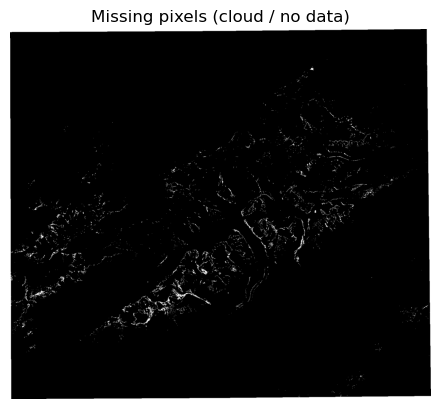

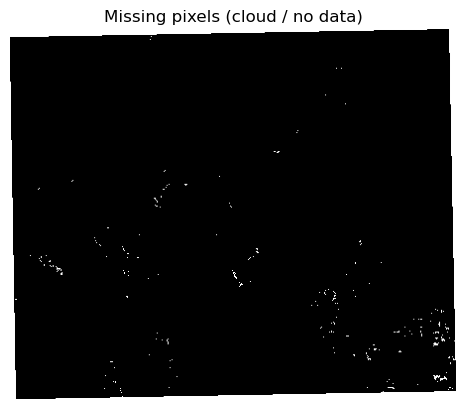

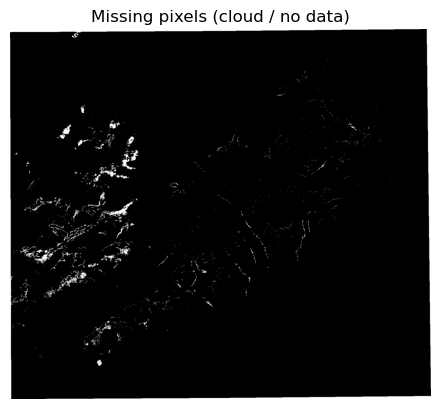

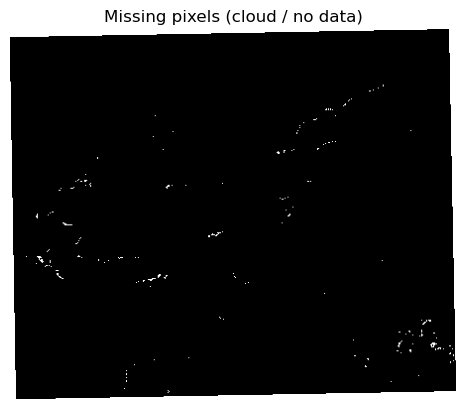

In [150]:
# Visualize missing data
for file_name in tif_files:
    mask = data[file_name]["valid_mask"]

    plt.imshow(~mask, cmap="gray")
    plt.title("Missing pixels (cloud / no data)")
    plt.axis("off")
    plt.show()


## Training set

In [151]:
def compute_normalization_stats(train_images):
    """
    train_images: list of (img, valid_mask) tuples
    img shape: (bands, H, W)
    """
    band_values = [[] for _ in range(train_images[0][0].shape[0])]

    for img, mask in train_images:
        for b in range(img.shape[0]):
            band_values[b].append(img[b][mask])

    means = np.array([np.mean(np.concatenate(v)) for v in band_values])
    stds  = np.array([np.std(np.concatenate(v))  for v in band_values])

    return means, stds


In [152]:
#Compute normalization statistics: on train images using valide pixels only

train_imgs = [
    load_image_and_mask(os.path.join(images_path, "L5_Glacier_train_2010_30m.tif"))[:2],
    load_image_and_mask(os.path.join(images_path, "L8_Glacier_train_2016_30m.tif"))[:2],
]

means, stds = compute_normalization_stats(train_imgs)


In [153]:
#Patch extraction from raw images + mask

def extract_patches(img, mask, patch_size=32, stride=32, valid_thresh=0.9, source=None):
    B, H, W = img.shape
    patches = []

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = img[:, y:y+patch_size, x:x+patch_size]
            #patch_mask = mask[y:y+patch_size, x:x+patch_size]
            if np.isnan(patch).any():
                continue


            #if patch_mask.mean() >= valid_thresh:
            patches.append({
                "data": patch,
                "y": y,
                "x": x,
                "source": source                                })

    return patches


In [154]:
# Apply to all training images
train_files = [
    ("L5_Glacier_train_2010_30m.tif", "2010"),
    ("L8_Glacier_train_2016_30m.tif", "2016"),
]

train_patches = []

for fname, year in train_files:
    img, mask, _ = load_image_and_mask(os.path.join(images_path, fname))

    patches = extract_patches(
        img,
        mask,
        patch_size=32,
        stride=32,
        source=year   # THIS must never be None
    )

    train_patches.extend(patches)

print("Total TRAIN patches:", len(train_patches))



Total TRAIN patches: 3267


In [155]:
print("Mabe need for data augmentation using random flip patch")

'''# pseudo
if random() < 0.5:
    patch = flip(patch)
'''

Mabe need for data augmentation using random flip patch


'# pseudo\nif random() < 0.5:\n    patch = flip(patch)\n'

In [156]:
p_raw = train_patches[0]["data"]
print("NaNs before normalization:", np.isnan(p_raw).any())


NaNs before normalization: False


In [157]:
def normalize_patch(patch, means, stds):
    return (patch - means[:, None, None]) / stds[:, None, None]


In [158]:
#Normalize training dataset only
train_patches_norm = [
    {
        **p,
        "data": normalize_patch(p["data"], means, stds)
    }
    for p in train_patches
]


assert not np.isnan(train_patches_norm[0]["data"]).any()


In [159]:
# Build X_train from train_patches
X_train = np.stack([p["data"] for p in train_patches])

### Label

In [160]:
def rasterize_glacier_binary(shp_path, reference_raster_path):
    """
    Returns a binary glacier mask:
    1 = glacier
    0 = non-glacier
    """
    gdf = gpd.read_file(shp_path)

    with rasterio.open(reference_raster_path) as src:
        transform = src.transform
        height = src.height
        width = src.width
        crs = src.crs

    # Ensure CRS match
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)

    shapes = [(geom, 1) for geom in gdf.geometry]

    glacier_mask = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

    return glacier_mask



In [161]:
glacier_mask_2010 = rasterize_glacier_binary(
    glacier_2010_path,
    os.path.join(images_path, "L5_Glacier_train_2010_30m.tif")
)

glacier_mask_2016 = rasterize_glacier_binary(
    glacier_2016_path,
    os.path.join(images_path, "L8_Glacier_train_2016_30m.tif")
)



In [162]:
print(glacier_mask_2016.shape)
np.unique(glacier_mask_2016)
# → array([0, 1])


(1493, 1700)


array([0, 1], dtype=uint8)

In [163]:
def label_patch(y, x, glacier_mask, patch_size=32, threshold=0.5):
    patch_mask = glacier_mask[y:y+patch_size, x:x+patch_size]
    return int(patch_mask.mean() >= threshold)



In [164]:
y_train = []

for p in train_patches:
    if p["source"] == "2010":
        lbl = label_patch(p["y"], p["x"], glacier_mask_2010)
    elif p["source"] == "2016":
        lbl = label_patch(p["y"], p["x"], glacier_mask_2016)
    else:
        raise ValueError("Unknown source")

    y_train.append(lbl)

y_train = np.array(y_train, dtype=np.uint8)



In [165]:
print("Glacier patches:", (y_train == 1).sum())
print("Non-glacier patches:", (y_train == 0).sum())


Glacier patches: 213
Non-glacier patches: 3054


In [166]:
# Fraction of glacier pixels in the whole AOI
glacier_fraction = glacier_mask_2016.mean()
print("Glacier pixel fraction:", glacier_fraction)

# Plot a few glacier / non-glacier patches
import matplotlib.pyplot as plt

def show_patch(p):
    # simple RGB using bands B4, B3, B2 -> indices 0,1,2 if in that order
    rgb = p["data"][0:3, :, :]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
    plt.imshow(rgb.transpose(1, 2, 0))
    plt.axis("off")


Glacier pixel fraction: 0.13800914069579606


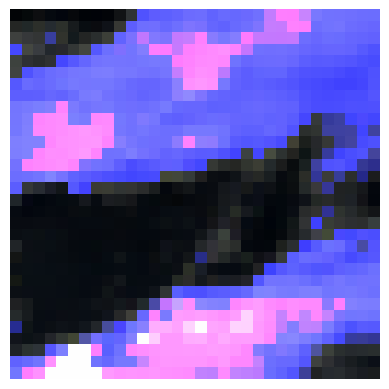

In [167]:

# One glacier patch
for p, y in zip(train_patches, y_train):
    if y == 1:
        show_patch(p)
        break



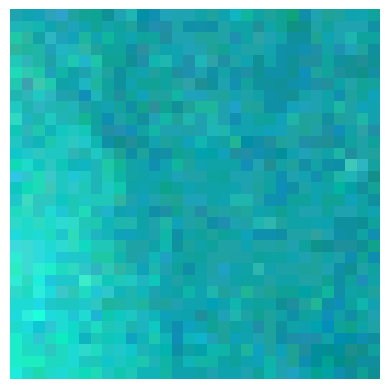

In [168]:

# One non-glacier patch

for p, y in zip(train_patches, y_train):
    if y == 0:
        show_patch(p)
        break



In [169]:
print(len(train_patches))
print(X_train.shape)
print(y_train.shape)


3267
(3267, 6, 32, 32)
(3267,)


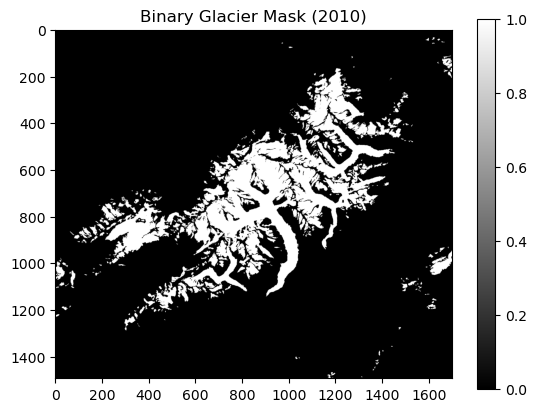

In [171]:
import matplotlib.pyplot as plt

plt.imshow(glacier_mask_2010, cmap="gray")
plt.title("Binary Glacier Mask (2010)")
plt.colorbar()
plt.show()

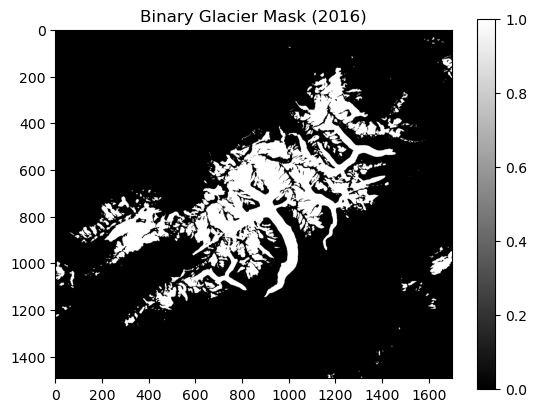

In [170]:
import matplotlib.pyplot as plt

plt.imshow(glacier_mask_2016, cmap="gray")
plt.title("Binary Glacier Mask (2016)")
plt.colorbar()
plt.show()



## Validation set

In [ ]:
#Apply to validation images

val_files = [
    "L5_Glacier_val_2010_30m.tif",
    "L8_Glacier_val_2016_30m.tif",
]

val_patches = []

for fname in val_files:
    img, mask, _ = load_image_and_mask(os.path.join(images_path, fname))

    patches = extract_patches(
        img,
        mask,
        patch_size=32,
        stride=32,
        valid_thresh=0.9
    )

    val_patches.extend(patches)

print("Total VAL patches:", len(val_patches))

In [ ]:
#Normalize validation dataset with training stat???
val_patches_norm = [
    {
        **p,
        "data": normalize_patch(p["data"], means, stds)
    }
    for p in val_patches
]